## Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn
import tensorflow as tf

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
assert version.parse(tf.__version__) >= version.parse("2.8.0")

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [3]:
import os
print("Number of physical CPUs:", os.cpu_count())

Number of physical CPUs: 2


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

In [6]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

## 10.
_Exercise: Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as [CIFAR10](https://homl.info/122) if you want a bigger challenge. Regardless of the dataset you're using, follow these steps:_
* Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.
* Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer.
* Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train / 255.0
X_test = X_test / 255

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [8]:
tf.random.set_seed(42)

denoising_encoder = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(0.1),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu")
])

In [9]:
denoising_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(16 * 16 * 32, activation="relu"),
    tf.keras.layers.Reshape([16, 16, 32]),
    tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                    padding="same", activation="sigmoid")
])

In [10]:
denoising_ae = tf.keras.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer="nadam",
                     metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_test, X_test))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.6034 - mse: 0.0230 - val_loss: 0.6005 - val_mse: 0.0189
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.5702 - mse: 0.0090 - val_loss: 0.5783 - val_mse: 0.0110
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.5664 - mse: 0.0075 - val_loss: 0.5794 - val_mse: 0.0112
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5651 - mse: 0.0070 - val_loss: 0.5697 - val_mse: 0.0080
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.5642 - mse: 0.0067 - val_loss: 0.5722 - val_mse: 0.0090
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.5638 - mse: 0.0065 - val_loss: 0.5670 - val_mse: 0.0073
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5633 - mse: 0.0064 - val_loss: 0.5660 - val_mse: 0.0068
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.5631 - mse: 0.0063 - val_loss: 0.5664 - val_mse: 0.0071
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


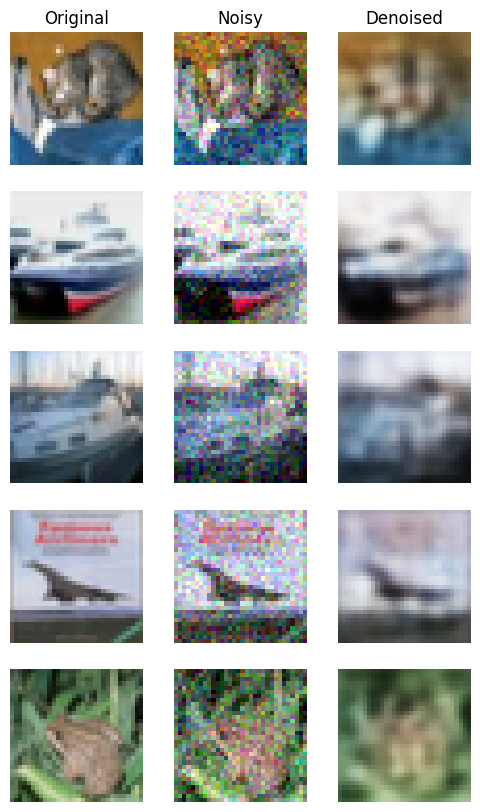

In [11]:
import numpy as np
import matplotlib.pyplot as plt

n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title('Original')
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(new_images_noisy[index].clip(0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title('Noisy')
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title('Denoised')

plt.show()

## 11.
_Exercise: Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples._


In [12]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [13]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [14]:
tf.random.set_seed(42)

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [15]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [16]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [17]:
#latent_loss = -0.5 * tf.reduce_sum(
#    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
#    axis=-1)
#variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [18]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0524 - val_loss: 0.0221
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0211 - val_loss: 0.0194
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0189 - val_loss: 0.0183
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0178 - val_loss: 0.0175
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0171 - val_loss: 0.0171
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0166 - val_loss: 0.0166
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0162 - val_loss: 0.0163
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 9/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0157 - val_loss: 0.0159
Epoch 10/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0155 - val_loss: 0.0158
Epoch 11/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0155
Epoch 12/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/ste

In [19]:
import matplotlib.pyplot as plt
import numpy as np

#def plot_reconstructions(model, images=X_valid, n_images=5):
#    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
#    fig = plt.figure(figsize=(n_images * 1.5, 3))
#    for image_index in range(n_images):
#        plt.subplot(2, n_images, 1 + image_index)
#        plt.imshow(images[image_index], cmap="binary")
#        plt.axis("off")
#        plt.subplot(2, n_images, 1 + n_images + image_index)
#        plt.imshow(reconstructions[image_index], cmap="binary")
#        plt.axis("off")
#
#plot_reconstructions(variational_ae)
#plt.show()

Generate Fashion Images

Let's generate a few random codings and decode them:

In [20]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

Now let's plot these images:

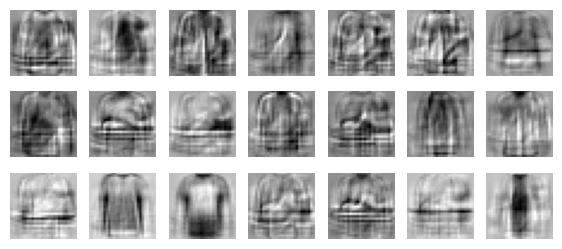

In [21]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
#save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()

Now let's perform semantic interpolation between 2 images:

In [22]:
tf.random.set_seed(42)
codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)  # axis 3 looks best in this case
images = variational_decoder(codings).numpy()

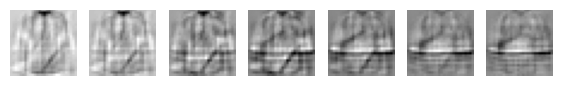

In [23]:
plot_multiple_images(images)
#save_fig("semantic_interpolation_plot", tight_layout=False)
plt.show()

## 12.
_Exercise: Train a DCGAN to tackle the image dataset of your choice, and use it to generate images. Add experience replay and see if this helps. Turn it into a conditional GAN where you can control the generated class._


We'll use the Fashion MNIST dataset for this exercise, which consists of 28x28 grayscale images of fashion items.

In [24]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load Fashion MNIST dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

Define the Generator

In [25]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = make_generator_model()

Define the Discriminator

In [26]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()

Define the Loss and Optimizers

In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Training Loop

In [28]:
import time

# Experience replay buffer
replay_buffer = []

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    batch_size = tf.shape(images)[0]  # Use tf.shape instead of images.shape[0]
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Experience replay
    if len(replay_buffer) > 1000:
        replay_buffer.pop(0)
    replay_buffer.append(generated_images)

@tf.function
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train(train_dataset, EPOCHS)

Time for epoch 1 is 3.508255958557129 sec
Time for epoch 2 is 0.0728902816772461 sec
Time for epoch 3 is 0.06285500526428223 sec
Time for epoch 4 is 0.06063389778137207 sec
Time for epoch 5 is 0.06588315963745117 sec
Time for epoch 6 is 0.06180310249328613 sec
Time for epoch 7 is 0.06557154655456543 sec
Time for epoch 8 is 0.06395578384399414 sec
Time for epoch 9 is 0.06897354125976562 sec
Time for epoch 10 is 0.0734407901763916 sec
Time for epoch 11 is 0.07149291038513184 sec
Time for epoch 12 is 0.06620478630065918 sec
Time for epoch 13 is 0.06379199028015137 sec
Time for epoch 14 is 0.06514358520507812 sec
Time for epoch 15 is 0.06640076637268066 sec
Time for epoch 16 is 0.07091355323791504 sec
Time for epoch 17 is 0.0661461353302002 sec
Time for epoch 18 is 0.06424784660339355 sec
Time for epoch 19 is 0.06387805938720703 sec
Time for epoch 20 is 0.07479381561279297 sec
Time for epoch 21 is 0.0700533390045166 sec
Time for epoch 22 is 0.06630325317382812 sec
Time for epoch 23 is 0.06

Experience replay involves storing generated images in a buffer and occasionally using them in training to prevent forgetting and improve stability. In the code above, the `replay_buffer` is used to store generated images, and they are periodically revisited during training.

To turn the DCGAN into a Conditional GAN, we modify the generator and discriminator to accept label information along with the noise vector and input images.

Update the Generator

In [29]:
def make_conditional_generator_model(num_classes):
    model = tf.keras.Sequential()
    model.add(layers.Embedding(num_classes, 100, input_length=1))
    model.add(layers.Flatten())
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

conditional_generator = make_conditional_generator_model(num_classes=10)

Update the Discriminator

In [30]:
def make_conditional_discriminator_model(num_classes):
    image_input = layers.Input(shape=(28, 28, 1))
    label_input = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, 28*28)(label_input)
    label_embedding = layers.Reshape((28, 28, 1))(label_embedding)
    concatenated = layers.Concatenate()([image_input, label_embedding])

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(concatenated)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    output = layers.Dense(1)(x)

    return tf.keras.Model(inputs=[image_input, label_input], outputs=output)

conditional_discriminator = make_conditional_discriminator_model(num_classes=10)

When training the cGAN, include the label information along with the noise vector for the generator and the image for the discriminator.

In [31]:
@tf.function
def conditional_train_step(images, labels):
    labels = tf.cast(labels, tf.int32)
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate label embeddings and concatenate with noise
        label_embedding = conditional_generator.get_layer('embedding')(labels)
        # Reshape label embedding to match noise shape
        label_embedding = tf.reshape(label_embedding, [batch_size, noise_dim])
        noise_and_labels = tf.concat([noise, label_embedding], axis=1)

        generated_images = conditional_generator(noise_and_labels, training=True)

        real_output = conditional_discriminator([images, labels], training=True)
        fake_output = conditional_discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, conditional_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, conditional_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, conditional_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, conditional_discriminator.trainable_variables))

    # Experience replay
    if len(replay_buffer) > 1000:
        replay_buffer.pop(0)
    replay_buffer.append(generated_images)

## 13.
_Exercise: Go through KerasCV’s excellent [Stable Diffusion tutorial](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/), and generate a beautiful
drawing of a salamander reading a book. If you post your best drawing on X, please tag him at @aureliengeron. He would love to see your creations!_

###Overview

In this guide, we will show how to generate novel images based on a text prompt using the KerasCV implementation of stability.ai's text-to-image model, [Stable Diffusion](https://github.com/CompVis/stable-diffusion).

Stable Diffusion is a powerful, open-source text-to-image generation model. While there exist multiple open-source implementations that allow you to easily create images from textual prompts, KerasCV's offers a few distinct advantages. These include XLA compilation and mixed precision support, which together achieve state-of-the-art generation speed.

In this guide, we will explore KerasCV's Stable Diffusion implementation, show how to use these powerful performance boosts, and explore the performance benefits that they offer.

**Note:** To run this guide on the `torch` backend, please set `jit_compile=False` everywhere. XLA compilation for Stable Diffusion does not currently work with torch.

To get started, let's install a few dependencies and sort out some imports:

In [32]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras  # Upgrade to Keras 3.

In [33]:
import time
import keras_cv
import keras
import matplotlib.pyplot as plt

###Introduction

Unlike most tutorials, where we first explain a topic then show how to implement it, with text-to-image generation it is easier to show instead of tell.

Check out the power of `keras_cv.models.StableDiffusion()`.

First, we construct a model:

In [34]:
model = keras_cv.models.StableDiffusion(
    img_width=512, img_height=512, jit_compile=False
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


Next, we give it a prompt:

In [35]:
images = model.text_to_image("photograph of an astronaut riding a horse", batch_size=3)


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(images)

ValueError: Exception encountered when calling DiffusionModel.call().

[1mInvalid input shape for input Tensor("data_2:0", shape=(3, 77, 768), dtype=float32). Expected shape (None, 64, 64, 4), but input has incompatible shape (3, 77, 768)[0m

Arguments received by DiffusionModel.call():
  • inputs={'latent': 'tf.Tensor(shape=(3, 64, 64, 4), dtype=float32)', 'timestep_embedding': 'tf.Tensor(shape=(3, 320), dtype=float32)', 'context': 'tf.Tensor(shape=(3, 77, 768), dtype=float32)'}
  • training=False
  • mask={'latent': 'None', 'timestep_embedding': 'None', 'context': 'None'}